<a href="https://colab.research.google.com/github/mariamhergnyan/Molecular_Simulations_exam/blob/main/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run these before working.

In [1]:
!pip install notebook==6.5.5  > /dev/null

In [2]:
!pip install ipywidgets > /dev/null

In [3]:
!pip install pyemma > /dev/null
!pip install mdshare > /dev/null
#4 minutes

In [4]:
!pip install nglview > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires notebook==6.5.5, but you have notebook 7.0.7 which is incompatible.


In [5]:
!pip install biopython > /dev/null

In [6]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mdshare
import pyemma
# for visualization of molecular structures:
import nglview
import mdtraj
from threading import Timer
from nglview.player import TrajectoryPlayer
from Bio.PDB import PDBParser
import pyemma.util.contexts as contexts

from IPython.display import display
from threading import Timer
from google.colab import widgets
import ipywidgets
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [8]:
#mdshare.fetch is used for fetching from their server.
#In my case I have it locally, so it just should be the path

In [9]:
pdb = '/content/lb6-filtered.pdb'
files = '/content/lb6-filtered.xtc'


#Feature selection
Since we don't know which features describe the best the molecule, we do feature selecting with VAMP(Variational Approach for Markov Proceess). We utilize the VAMP2 score which shows the kinetic variance. The minimum VAMP2 score is 1. The higher the score, the better the given feature describes the molecule. Here we only do the selection based on the features of the backbone and not the side chains.

In [10]:
torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)
labels = ['backbone\ntorsions']

positions_feat = pyemma.coordinates.featurizer(pdb)
positions_feat.add_selection(positions_feat.select_Backbone())
positions_data = pyemma.coordinates.load(files, features=positions_feat)
labels += ['backbone atom\npositions']

distances_feat = pyemma.coordinates.featurizer(pdb)
distances_feat.add_distances(
    distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False)
distances_data = pyemma.coordinates.load(files, features=distances_feat)
labels += ['backbone atom\ndistances']

In [21]:
print(torsions_data.shape)

(10836, 48)


In [11]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
#compute a cross validated vamp 2 score
    # we temporarily suppress very short-lived progress bars
    with contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores

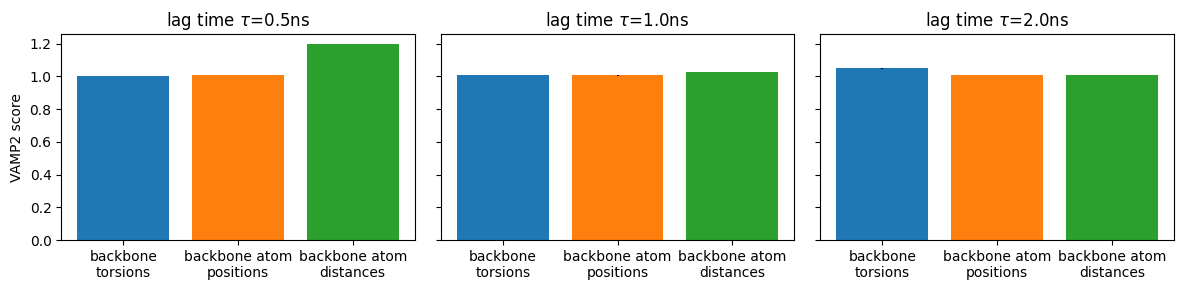

In [23]:
dim = 1

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 20]):
    torsions_scores = score_cv(torsions_data, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    positions_scores = score_cv(positions_data, lag=lag, dim=dim)
    scores += [positions_scores.mean()]
    errors += [positions_scores.std()]
    distances_scores = score_cv(distances_data, lag=lag, dim=dim)
    scores += [distances_scores.mean()]
    errors += [distances_scores.std()]
    ax.bar(labels, scores, yerr=errors, color=['C0', 'C1', 'C2'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()

Trying with different lag times and dimensions

Computing VAMP score for dim=1, lag=1
Computing VAMP score for dim=2, lag=1


RuntimeError: requested more output dimensions (2) than dimension of input data (1)

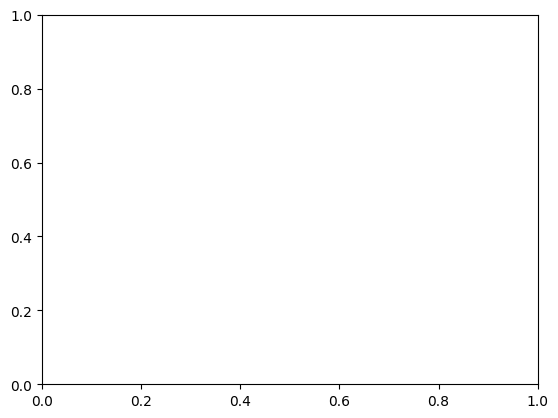

In [28]:
lags = [1, 2, 5, 10, 20]
#dims = [1]
dims = [i + 1 for i in range(10)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = []
    for dim in dims:
        print("Computing VAMP score for dim={}, lag={}".format(dim, lag))
        score = score_cv(torsions_data, dim, lag)
        scores_.append(score)
    scores_ = np.array(scores_)

    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()


In [30]:
pdb_1= mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data')
files_1 = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data')
print(pdb_1)
print(files_1)



data/pentapeptide-impl-solv.pdb
['data/pentapeptide-00-500ns-impl-solv.xtc', 'data/pentapeptide-01-500ns-impl-solv.xtc', 'data/pentapeptide-02-500ns-impl-solv.xtc', 'data/pentapeptide-03-500ns-impl-solv.xtc', 'data/pentapeptide-04-500ns-impl-solv.xtc', 'data/pentapeptide-05-500ns-impl-solv.xtc', 'data/pentapeptide-06-500ns-impl-solv.xtc', 'data/pentapeptide-07-500ns-impl-solv.xtc', 'data/pentapeptide-08-500ns-impl-solv.xtc', 'data/pentapeptide-09-500ns-impl-solv.xtc', 'data/pentapeptide-10-500ns-impl-solv.xtc', 'data/pentapeptide-11-500ns-impl-solv.xtc', 'data/pentapeptide-12-500ns-impl-solv.xtc', 'data/pentapeptide-13-500ns-impl-solv.xtc', 'data/pentapeptide-14-500ns-impl-solv.xtc', 'data/pentapeptide-15-500ns-impl-solv.xtc', 'data/pentapeptide-16-500ns-impl-solv.xtc', 'data/pentapeptide-17-500ns-impl-solv.xtc', 'data/pentapeptide-18-500ns-impl-solv.xtc', 'data/pentapeptide-19-500ns-impl-solv.xtc', 'data/pentapeptide-20-500ns-impl-solv.xtc', 'data/pentapeptide-21-500ns-impl-solv.xtc',

In [26]:
pyemma.plots.plot_feature_histograms(files, feature_labels=['$x$', '$y$']);

ValueError: Input data hast to be a numpy array. Did you concatenate your data?

In [ ]:
warnings.resetwarnings()
#widgets don't work on google colab

In [ ]:
# Create an NGLview widget to display the PDB file - should tis display here? cuz it's not doing it
view = nglview.show_file(pdb)
#view.add_representation('cartoon')
#view.center()
#view

view = nglview.NGLWidget()
view.add_pdbid(pdb)
view.add_representation('cartoon')
view.center()
view

# 2nd cell
view._js("console.log(this.model.views)")

In [ ]:
traj = mdtraj.load(pdb)

# Create the widget
widget = nglview.show_mdtraj(traj)
widget.add_ball_and_stick()

# Display the widget
display(widget)

# Define a function to stop spinning and close the widget
def stop_spin():
    widget.player.spin = False
    widget.close()

# Set a timer to stop spinning and close the widget after 30 seconds
Timer(30, stop_spin).start()


In [ ]:
# # Parse the PDB file using BioPython's PDBParser
# parser = PDBParser()
# structure = parser.get_structure('my_structure', '/content/lb6-filtered.pdb')

# # Prepare coordinates for PyEmma
# coordinates = []
# for model in structure:
#     for chain in model:
#         for residue in chain:
#             for atom in residue:
#                 coordinates.append(atom.get_coord())

# # Convert coordinates to PyEmma's format (assuming 3D coordinates)
# coordinates = [list(atom_coord) for atom_coord in coordinates]


# # Perform PyEmma analysis (example: PCA)
# #pca = pyemma.coordinates.pca(coordinates)


In [ ]:
# # Define the file path for saving the coordinates
# txt_file = '/content/coordinates.txt'


# # Write coordinates to a text file
# with open(txt_file, 'w') as file:
#     for coord in coordinates:
#         file.write(','.join(map(str, coord)) + '\n')
